# Восстановление золота из руды

**Описание проекта:** необходимо подготовить прототип модели машинного обучения для компании «Цифра», которая разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цели проекта:** 
1. подготовить данные;
2. провести исследовательский анализ данных;
3. построить и обучить модель для предсказания коэффициента восстановления золота из руды.

**Описание данных:** предоставлены данные с параметрами добычи и очистки на каждом этапе производства. 

## Оглавление
1. [Подготовка данных](#1)
    <br>1.1. [Загрузка файлов и общая информация о данных](#1.1)
    <br>1.2. [Проверка расчёта эффективности обогащения](#1.2)
    <br>1.3. [Анализ прищнаков, недоступных в тестовой выборке](#1.3)
    <br>1.4. [Предобработка данных](#1.4)
2. [Анализ данных](#2)
    <br>2.1. [Концентрации металлов на различных этапах очистки](#2.1)
    <br>2.2. [Сравнение распределений гранул сырья](#2.2)
    <br>2.3. [Исследование суммарной концентрации веществ на разных стадиях](#2.3)
3. [Модель](#3)
    <br>3.1. [Функция `weighted_smape`](#3.1)
    <br>3.2. [Обучение моделей](#3.2)
4. [Заключение](#4)

<a id="1"></a>
## 1. Подготовка данных

<a id="1.1"></a>
### 1.1. Загрузка файлов и общая информация о данных
Импортируем необходимые для работы модули и библиотеки. 

In [1]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option("display.max_rows", 90)
sns.set(rc={'figure.figsize':(10, 7)})

Считываем файлы:

In [2]:
data_train = pd.read_csv("/datasets/gold_recovery_train_new.csv")
data_test = pd.read_csv("/datasets/gold_recovery_test_new.csv")
data_full = pd.read_csv("/datasets/gold_recovery_full_new.csv")

Посмотрим на размеры выборок:

In [3]:
print(f"Размер обучающей выборки: {data_train.shape}")
print(f"Размер тестовой выборки: {data_test.shape}")
print(f"Размер всей выборки: {data_full.shape}")

Размер обучающей выборки: (14149, 87)
Размер тестовой выборки: (5290, 53)
Размер всей выборки: (19439, 87)


Убедимся, что файлы считались корректно.

In [4]:
display(data_train.head(5))
display(data_test.head(5))
display(data_full.head(5))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Посмотрим на общую информацию о данных в обучающей выборке.

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Данные не требуют приведения к каким-то другим типам (кроме признака `date`, о нём см. [п.1.4](#date)), однако в них есть пропуски. Посмотрим на их долю (в %).

In [6]:
data_train.isna().mean() * 100

date                                                   0.000000
final.output.concentrate_ag                            0.007068
final.output.concentrate_pb                            0.007068
final.output.concentrate_sol                           1.491271
final.output.concentrate_au                            0.000000
final.output.recovery                                  0.000000
final.output.tail_ag                                   0.000000
final.output.tail_pb                                   0.706764
final.output.tail_sol                                  0.035338
final.output.tail_au                                   0.000000
primary_cleaner.input.sulfate                          0.141353
primary_cleaner.input.depressant                       0.226164
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         0.706764
primary_cleaner.output.concentrate_ag                  0.000000
primary_cleaner.output.concentrate_pb   

Только для одного признака (`secondary_cleaner.output.tail_sol`) пропуски составляют значительную часть, чуть больше 11%. Вычислим долю объектов с пропусками для обучающей выборки. 

In [7]:
frac_1 = 1 - data_train.dropna().shape[0]/data_train.shape[0]
print(f"Доля пропущенных значений в обучающей выборке: {frac_1:.2%}")

Доля пропущенных значений в обучающей выборке: 22.14%


Если выбрасывать все объекты с пропусками из выборки, то будет потеряно больше 1/5 обучающей выборки. Однако в обучающей выборке есть признаки, которые для обучения моделей использоваться не могут, поскольку они отсутствуют в тестовой выборке. Посмотрим, какая доля объектов с пропусками пропадёт в такой "отредактированной" обучающей выборке.

In [8]:
frac_2 = 1 - data_train[data_test.columns].dropna().shape[0]/data_train.shape[0]
print(f"Доля пропущенных значений в обучающей выборке: {frac_2:.2%}")

Доля пропущенных значений в обучающей выборке: 10.39%


В два раза меньше. Это всё равно довольно много, однако можно попробовать удалить объекты с пропусками и обучать модели уже на такой выборке.

<a id="1.2"></a>
### 1.2. Проверка расчёта эффективности обогащения
Проверим расчёт эффективности обогащения на обучающей выборке для признака `rougher.output.recovery`, то есть обогащение после флотации. Эффективность обогащения рассчитывается по формуле:

$$Recovery = \frac{C(F -T)}{F(C -T)},$$

где 
<br>$C$ — доля золота в концентрате после флотации;
<br>$F$ — доля золота в сырье/концентрате до флотации;
<br>$T$ — доля золота в отвальных хвостах после флотации.

Выполним расчёт, а по полученным значениям и значениям признака найдём MAE.

In [9]:
c = data_train["rougher.output.concentrate_au"]
f = data_train["rougher.input.feed_au"]
t = data_train["rougher.output.tail_au"]

r = c*(f-t)/(f*(c-t)) * 100

print(f"Значение МАЕ: {abs(data_train['rougher.output.recovery'] - r).mean()}")

Значение МАЕ: 9.73512347450521e-15


Из-за ошибок округления МАЕ не равна нулю, однако полученная величина очень маленькая. Можно сделать вывод, что эффективность обогащения рассчитана правильно.

<a id="1.3"></a>
### 1.3. Анализ признаков, недоступных в тестовой выборке
Посмотрим, какие признаки отсутствуют в тестовой выборке.

In [10]:
print((data_train.columns ^ data_test.columns))

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

/tmp/ipykernel_93/164566098.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead
  print((data_train.columns ^ data_test.columns))


Отсутствующие в тестовой выборке признаки либо относятся к параметрам продукта, либо являются расчётными характеристиками. Они отсутствуют в тестовой выборке потому, что они неизвестны заранее, их можно вычислить только после проведения очистки или флотации.

<a id="1.4"></a>
### 1.4. Предобработка данных
Поскольку в п.1.1 было принято решение избавиться от объектов с пропусками, то какая-то другая предобработка данных не требуется. Можно проверить данные на наличие явных дубликатов.

In [11]:
print("Количество дубликатов")
print(" - в обучающей выборке:", data_train.duplicated().sum())
print(" - в тестовой выборке: ", data_test.duplicated().sum())

Количество дубликатов
 - в обучающей выборке: 0
 - в тестовой выборке:  0


Удалим из выборок объекты с пропусками.

In [12]:
data_train = data_train.loc[data_train[data_test.columns].dropna().index]
data_test = data_test.dropna()

<a id="date"></a>
Приведём признак `date` к типу `datetime` и заменим индексы во всех наборах данных. Это понадобится далее для создания ответов на тестовой выборке.

In [13]:
data_train["date"] = pd.to_datetime(data_train["date"], format="%Y-%m-%d %H:%M:%S")
data_test["date"] = pd.to_datetime(data_test["date"], format="%Y-%m-%d %H:%M:%S")
data_full["date"] = pd.to_datetime(data_full["date"], format="%Y-%m-%d %H:%M:%S")

data_train.set_index("date", inplace=True)
data_test.set_index("date", inplace=True)
data_full.set_index("date", inplace=True)

Теперь можно перейти к следующему этапу — исследовательскому анализу данных.

<a id="2"></a>
## 2. Анализ данных

<a id="2.1"></a>
### 2.1. Концентрации металлов на различных этапах очистки
Построим распределения концентрации металлов (золота, серебра и свинца) на различных этапах очистки.

In [14]:
postfix = ["au", "ag", "pb"]
stages = ["rougher.input.feed_", "rougher.output.concentrate_",
          "primary_cleaner.output.concentrate_", "final.output.concentrate_"]

stages_au = [stage + "au" for stage in stages]
stages_ag = [stage + "ag" for stage in stages]
stages_pb = [stage + "pb" for stage in stages]
all_stages = [stages_au, stages_ag, stages_pb]

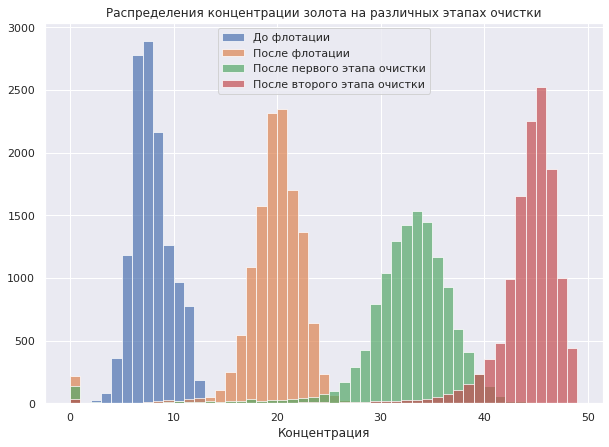

In [15]:
for stage in stages_au:
    data_train[stage].hist(bins=range(0, 50), alpha=0.7)
    plt.legend(["До флотации", "После флотации", 
                "После первого этапа очистки", 
                "После второго этапа очистки"])
    plt.title("Распределения концентрации золота на различных этапах очистки")
    plt.xlabel("Концентрация")

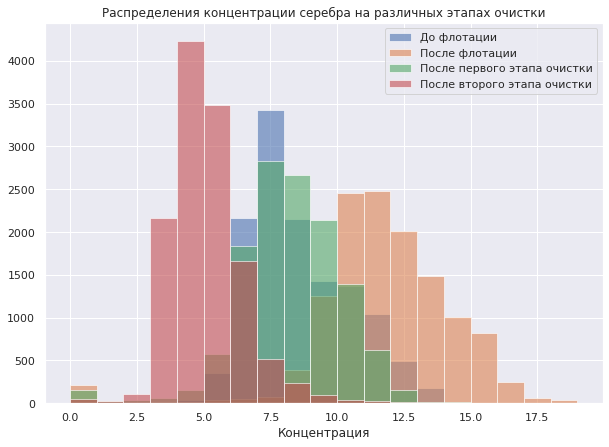

In [16]:
for stage in stages_ag:
    data_train[stage].hist(bins=range(0, 20), alpha=0.6)
    plt.legend(["До флотации", "После флотации", 
                "После первого этапа очистки", 
                "После второго этапа очистки"])
    plt.title("Распределения концентрации серебра на различных этапах очистки")
    plt.xlabel("Концентрация")

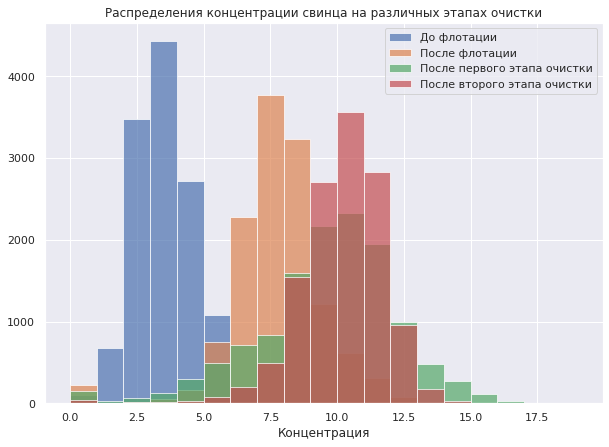

In [17]:
for stage in stages_pb:
    data_train[stage].hist(bins=range(0, 20), alpha=0.7)
    plt.legend(["До флотации", "После флотации", 
                "После первого этапа очистки", 
                "После второго этапа очистки"])
    plt.title("Распределения концентрации свинца на различных этапах очистки")
    plt.xlabel("Концентрация")

Посмотрим на **средние** концентрации металлов в образцах на каждом этапе: в смеси руды (до флотации), в черновом концентрате (после флотации), после первого этапа очистки и в финальном концентрате. 

In [18]:
means = [data_train[stage].mean().values for stage in all_stages]
pivot_concentration = pd.DataFrame(means, 
                                   columns=["До флотации", "После флотации", 
                                            "После первого этапа очистки", 
                                            "После второго этапа очистки"],
                                   index=["золото", "серебро", "свинец"])

pivot_concentration

,До флотации,После флотации,После первого этапа очистки,После второго этапа очистки
золото,7.887688,19.611547,32.454200,44.092279
серебро,8.582645,11.790123,8.248938,5.112701
свинец,3.525378,7.733154,9.624351,10.193810


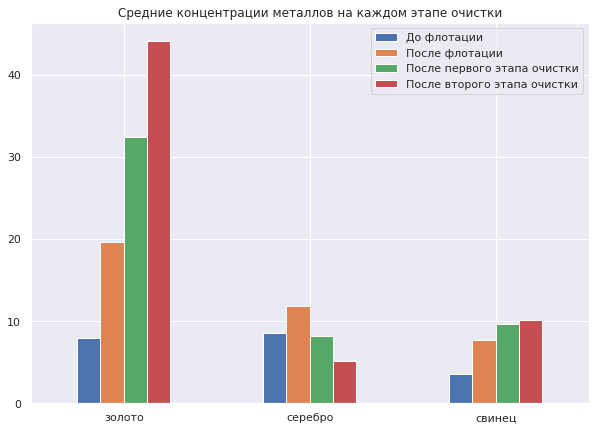

In [19]:
pivot_concentration.plot(kind="bar", rot=0,
                         title="Средние концентрации металлов на каждом этапе очистки");

На графиках видно, что концентрация золота с каждым этапом очистки растёт. Это логично, поскольку технологический процесс как раз направлен на увеличение концентрации золота в материале. При этом концентрация серебра падает (вероятно, его собирают отдельно от золота), а концентрация свинца увеличивается (сложно определить, по какой причине). 

<a id="2.2"></a>
### 2.2. Сравнение распределений гранул сырья
Сравним распределения размеров гранул сырья до и после флотации в обучающей и тестовой выборках. Сначала построим распределение размеров гранул сырья до флотации.

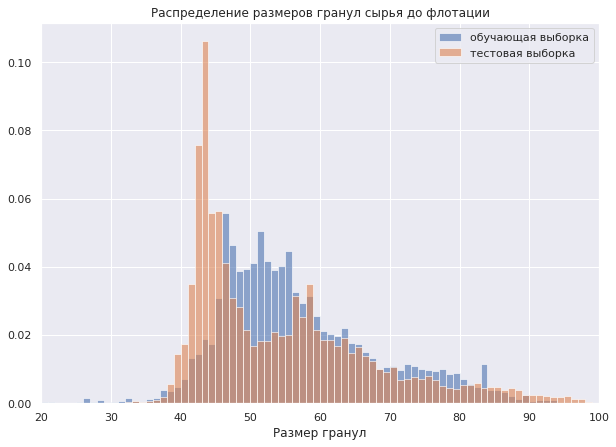

In [20]:
data_train["rougher.input.feed_size"].hist(bins=range(100), density=True, alpha=0.6)
data_test["rougher.input.feed_size"].hist(bins=range(100), density=True, alpha=0.6)
plt.title("Распределение размеров гранул сырья до флотации")
plt.xlim(20, 100)
plt.legend(["обучающая выборка", "тестовая выборка"])
plt.xlabel("Размер гранул");

Форма распределений несколько отличается, однако диапазон значений почти одинаковый. Посмотрим на распределения размеров гранул после флотации.

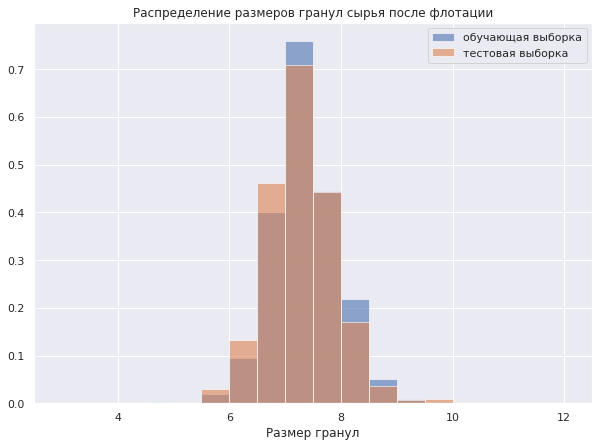

In [21]:
data_train["primary_cleaner.input.feed_size"].hist(bins=np.arange(0, 20, 0.5), density=True, alpha=0.6);
data_test["primary_cleaner.input.feed_size"].hist(bins=np.arange(0, 20, 0.5), density=True, alpha=0.6);
plt.xlim(2.5, 12.5)
plt.title("Распределение размеров гранул сырья после флотации")
plt.legend(["обучающая выборка", "тестовая выборка"])
plt.xlabel("Размер гранул");

Распределения практически совпадают. 

Хотя до флотации распределения размеров гранул несколько отличаются, скорее всего, это не окажет существенного негативного влияния на построенные модели.

<a id="2.3"></a>
### 2.3. Исследование суммарной концентрации веществ на разных стадиях
Исследуем суммарную концентрацию веществ на разных этапах очистки.

In [22]:
stages_sol = [stage + "sol" for stage in stages]
concentration_sums = []
for s1, s2, s3, s4 in zip(stages_au, stages_ag, stages_pb, stages_sol):
    concentration_sums.append(data_train[[s1, s2, s3, s4]].sum(axis=1))

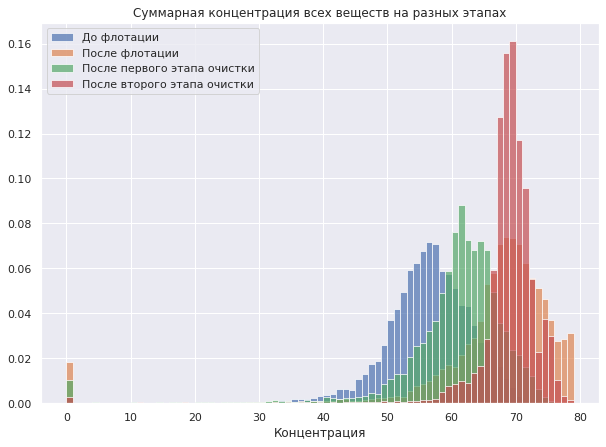

In [23]:
for substance in concentration_sums:
    substance.hist(bins=range(80), density=True, alpha=0.7)
    
plt.legend(["До флотации", "После флотации", 
            "После первого этапа очистки", 
            "После второго этапа очистки"])
plt.title("Суммарная концентрация всех веществ на разных этапах")
plt.xlabel("Концентрация");

Суммарная концентрация всех веществ в финальном концентрате гораздо больше, чем в смеси руды (то есть до флотации), что ожидаемо. Можно заметить, что после флотации и этапов очистки есть объекты с нулевым значением концентрации. Это довольно сомнительно, особенно если учесть, что таких объектов до флотации не было. Вероятно, эти аномальные значения концентраций появились в результате ошибок при записи или выгрузке данных. Поскольку передавать такие значения моделям будет не вполне корректно, такие объекты следует удалить и из обучающей выборки, и из тестовой, если они там присутствуют.

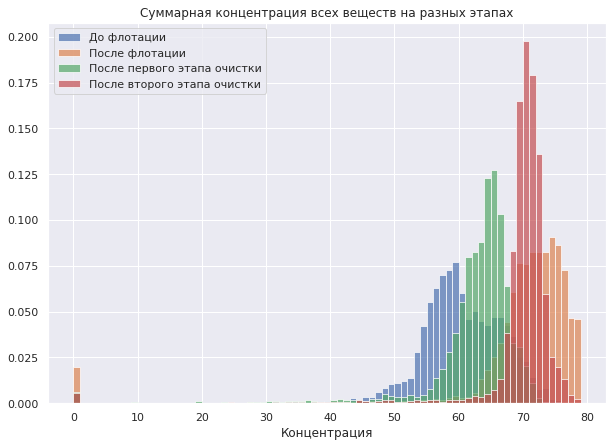

In [24]:
stages_sol = [stage + "sol" for stage in stages]
concentration_sums = []
for s1, s2, s3, s4 in zip(stages_au, stages_ag, stages_pb, stages_sol):
    concentration_sums.append(data_full.loc[data_test.index, [s1, s2, s3, s4]].sum(axis=1))
    
for substance in concentration_sums:
    substance.hist(bins=range(80), density=True, alpha=0.7)
    
plt.legend(["До флотации", "После флотации", 
            "После первого этапа очистки", 
            "После второго этапа очистки"])
plt.title("Суммарная концентрация всех веществ на разных этапах")
plt.xlabel("Концентрация");

В тестовой выборке тоже есть объекты с аномальными значениями суммарной концентрации. Все такие объекты далее будут удалены из обучающей и тестовой выборок.

<a id="3"></a>
## 3. Модель

<a id="3.1"></a>
### 3.1. Функция `weighted_smape`
Прежде чем начать обучать модели, напишем функцию `weighted_smape`, которая будет принимать два аргумента: истинные значения `y_true` и предсказанные значения `y_pred` признаков `rougher.output.recovery` и `final.output.recovery`. Метрика *sMAPE* задаётся следующим образом:

$$sMAPE = \frac{2}{N} \sum_{i=1}^{N} \frac{\left\lvert y_i-\hat{y_i}\right\rvert}{\left\lvert y_i\right\rvert - \left\lvert \hat{y_i}\right\rvert} \cdot 100 \%. $$

При этом итоговое *sMAPE* вычисляется так:

$$ Weighted\  sMAPE = 0.25 \cdot sMAPE(rougher) + 0.75 \cdot sMAPE(final) $$

In [25]:
def weighted_smape(y_true, y_pred):
    smape = ((np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean(axis=0)) * 100
    return np.array([0.25, 0.75]) @ smape

Подготовим данные для обучения моделей. 

In [26]:
for s1, s2, s3, s4 in zip(stages_au, stages_ag, stages_pb, stages_sol):
    
    train_indexes = data_train[(data_train[[s1, s2, s3, s4]].sum(axis=1) != 0)].index

    test_indexes = (data_full.loc[data_test.index]
                             .loc[(data_full.loc[data_test.index, [s1, s2, s3, s4]].sum(axis=1) != 0)]
                             .index)
    
    data_train = data_train.loc[train_indexes]
    data_test = data_test.loc[test_indexes]
    
X_train = data_train[data_test.columns]
X_test = data_test
y_train = data_train[["rougher.output.recovery", "final.output.recovery"]]
y_test = data_full.loc[data_test.index, ["rougher.output.recovery", "final.output.recovery"]]

Используем `StandartScaler`. 

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Теперь сделаем *scorer* из ранее написанной функции `weighted_smape`.

In [28]:
scorer = make_scorer(weighted_smape, greater_is_better=False)

Всё готово для обучения моделей.

<a id="3.2"></a>
### 3.2. Обучение моделей
Будем проверять три класса моделей: `LinearRegression`, `Lasso` и `Ridge` на кросс-валидации с количеством блоков равным 5 и ранее написанным *scorer*. Чтобы оценить адекватность моделей воспользуемся моделью `DummyRegressor`.

In [29]:
cv_scores = []

linreg = LinearRegression()
cv_scores.append(-cross_val_score(linreg, X_train, y_train, cv=5, scoring=scorer).mean())

In [30]:
params = {"alpha": [10**i for i in range(-3, 4)]}

lasso = Lasso(random_state=42)
reg = GridSearchCV(lasso, param_grid=params, scoring=scorer, cv=5)
reg.fit(X_train, y_train)

cv_scores.append(-reg.best_score_)
print("Лучшее значение параметра alpha:", reg.best_params_["alpha"])

Лучшее значение параметра alpha: 1


In [31]:
params = {"alpha": [10**i for i in range(-3, 4)]}

ridge = Ridge(random_state=42)
reg = GridSearchCV(ridge, param_grid=params, scoring=scorer, cv=5)
reg.fit(X_train, y_train)

cv_scores.append(-reg.best_score_)
print("Лучшее значение параметра alpha:", reg.best_params_["alpha"])

Лучшее значение параметра alpha: 1000


In [32]:
dummy = DummyRegressor(strategy="mean")
cv_scores.append(-cross_val_score(dummy, X_train, y_train, cv=5, scoring=scorer).mean())

Значения *sMAPE* на обучающей выборке приведены в таблице ниже.

In [33]:
pd.DataFrame(cv_scores, columns=["sMAPE"], index=["Linear Regression", 
                                                  "Lasso", "Ridge", "Dummy"])

,sMAPE
Linear Regression,9.407758
Lasso,8.301435
Ridge,8.609429
Dummy,9.183719


Минимальное значение метрики у модели `Lasso`, при этом обычная линейная регрессия без регуляризации справилась даже хуже, чем `DummyRegressor`. Таким образом, `Lasso` — лучшая из рассмотренных моделей. Проверим все модели на тестовой выборке.

In [34]:
cv_scores = []

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
cv_scores.append(weighted_smape(y_test, y_pred))

lasso = Lasso(alpha=1, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
cv_scores.append(weighted_smape(y_test, y_pred))

ridge = Ridge(alpha=1000, random_state=42)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
cv_scores.append(weighted_smape(y_test, y_pred))

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
cv_scores.append(weighted_smape(y_test, y_pred))

Результаты проверки моделей на тестовой выборке приведены в таблице ниже.

In [35]:
pd.DataFrame(cv_scores, columns=["sMAPE"], index=["Linear Regression", 
                                                  "Lasso", "Ridge", "Dummy"])

,sMAPE
Linear Regression,7.183387
Lasso,6.263457
Ridge,6.896952
Dummy,7.649474


Модель `Lasso` оказалась лучшей и на тестовой выборке. При этом на тестовой выборке все модели лучше, чем `DummyRegressor`.

<a id="4"></a>
## 4. Заключение
В проекте были выполнены:
* предобработка данных;
* исследование концентрации металлов на различных стадиях очистки;
* исследование суммарных концентраций всех веществ в материале на различных этапах;
* исследование различных моделей машинного обучения для определения значений эффективности обогащения чернового концентрата и эффективности обогащения финального концентрата;
* проверка лучшей модели (`Lasso`) на тестовой выборке.